<a href="https://colab.research.google.com/github/kanikachitnis1018/Summarizer/blob/main/flowchart_converter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install torch

In [ ]:
!sudo apt-get update
!sudo apt-get install poppler-utils
!pip install pdf2image pytesseract Pillow

Hit:1 https://cli.github.com/packages stable InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading packag

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import re
from pdf2image import convert_from_path # Make sure to run the installation cell first
from PIL import Image
import pytesseract
import os

In [ ]:
from google.colab import files
from pdf2image import convert_from_path
import cv2, numpy as np, pytesseract

In [ ]:
uploaded = files.upload()
pdf_path = list(uploaded.keys())[0]
pages = convert_from_path(pdf_path)

def deskew(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)
    coords = np.column_stack(np.where(gray > 0))
    angle = cv2.minAreaRect(coords)[-1]
    angle = -(90 + angle) if angle < -45 else -angle
    (h, w) = image.shape[:2]
    M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
    return cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

opencv_images = list(map(lambda p: cv2.cvtColor(np.array(p), cv2.COLOR_RGB2BGR), pages))
deskewed_images = list(map(deskew, opencv_images))
texts = list(map(lambda img: pytesseract.image_to_string(img), deskewed_images))
extracted_text = "\n".join(texts)

Saving Lab_Guideline.pdf to Lab_Guideline (1).pdf


In [ ]:
text_to_be_split = extracted_text


paragraphs = text_to_be_split.split("\n\n")

paragraphs

['Lab_Guideline.ipynb - Colaboratory https://colab.research.google.com/drive/12nwO9RoKtDjGypF8Arl4Xu...',
 '1 of 3',
 'Here are some common notes and rules that apply to all the labs.\nLab X is released with two files:',
 'e Lab_X.ipynb: the Python notebook that includes all the tasks;\ne Lab_X.py: a template file to which you will need to copy your implementation code, so that\ngrading can be done via unit test.',
 'Total score: To be more intuitive, the lab itself will be graded out of 100 points. It will be doubled\nto make 200 points, to be consistent with the syllabus.',
 'Late policy: Late submissions will not be accepted in any case, unless there is a documented\npersonal emergency. Arrangements must be made with the instructor as soon as possible after\nthe emergency arises, preferably well before the deadline.',
 'Group submission: lf you are doing a lab as a group work, only one member of each group needs\nto submit. Make sure that you specify your teammates when submitting o

In [ ]:
import re

cleaned_paras = list(
    filter(
        None,
        map(
            lambda para: re.sub(r'[^a-zA-Z0-9.,;:!?()\'" -]', '',
                re.sub(r'\s+', ' ', para.strip())
            ),
            paragraphs
        )
    )
)

_ = list(map(lambda i_p: print(f"Paragraph {i_p[0]+1}: {i_p[1]}\n"), enumerate(cleaned_paras)))


Paragraph 1: LabGuideline.ipynb - Colaboratory https:colab.research.google.comdrive12nwO9RoKtDjGypF8Arl4Xu...

Paragraph 2: 1 of 3

Paragraph 3: Here are some common notes and rules that apply to all the labs. Lab X is released with two files:

Paragraph 4: e LabX.ipynb: the Python notebook that includes all the tasks; e LabX.py: a template file to which you will need to copy your implementation code, so that grading can be done via unit test.

Paragraph 5: Total score: To be more intuitive, the lab itself will be graded out of 100 points. It will be doubled to make 200 points, to be consistent with the syllabus.

Paragraph 6: Late policy: Late submissions will not be accepted in any case, unless there is a documented personal emergency. Arrangements must be made with the instructor as soon as possible after the emergency arises, preferably well before the deadline.

Paragraph 7: Group submission: lf you are doing a lab as a group work, only one member of each group needs to submit. Ma

In [ ]:
import nltk
from nltk.tokenize import sent_tokenize
from itertools import chain
from transformers import BertTokenizer, BertModel

nltk.download("punkt_tab")

sentences = list(chain.from_iterable(map(sent_tokenize, cleaned_paras)))

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = BertModel.from_pretrained("bert-base-uncased")

encoded = tokenizer(    # converts sentences to tokens
    sentences,
    padding=True,
    truncation=True,
    return_tensors="pt"
)

with torch.no_grad():   # converts tokens to token embeddings
    outputs = model(**encoded)

embeddings = outputs.last_hidden_state    # converts token embeddings to sentence embeddings
sentence_embeddings = embeddings.mean(dim=1)

sentences_per_para = list(map(sent_tokenize, cleaned_paras))
para_lengths = list(map(len, sentences_per_para))

sentence_groups = torch.split(sentence_embeddings, para_lengths)

In [ ]:
import torch.nn.functional as F
from operator import itemgetter

def summarize_all_paragraphs(sentence_groups, sentences_per_para, k=2):
    def summarize_one(group_sents):
        group, para_sents = group_sents
        if group.size(0) == 0:
            return ""

        para_embedding = group.mean(dim=0, keepdim=True)
        scores = F.cosine_similarity(group, para_embedding)
        k_safe = min(k, group.size(0))

        top_idx = scores.topk(k_safe).indices
        sorted_idx, _ = torch.sort(top_idx)

        selected = itemgetter(*sorted_idx.tolist())(para_sents)

        if isinstance(selected, tuple):
            return " ".join(selected)
        else:
            return selected

    return list(map(summarize_one, zip(sentence_groups, sentences_per_para)))


In [ ]:
local_summaries = summarize_all_paragraphs(sentence_groups, sentences_per_para, k=4)

local_summaries

['LabGuideline.ipynb - Colaboratory https:colab.research.google.comdrive12nwO9RoKtDjGypF8Arl4Xu...',
 '1 of 3',
 'Here are some common notes and rules that apply to all the labs. Lab X is released with two files:',
 'e LabX.ipynb: the Python notebook that includes all the tasks; e LabX.py: a template file to which you will need to copy your implementation code, so that grading can be done via unit test.',
 'Total score: To be more intuitive, the lab itself will be graded out of 100 points. It will be doubled to make 200 points, to be consistent with the syllabus.',
 'Late policy: Late submissions will not be accepted in any case, unless there is a documented personal emergency. Arrangements must be made with the instructor as soon as possible after the emergency arises, preferably well before the deadline.',
 'Group submission: lf you are doing a lab as a group work, only one member of each group needs to submit. Make sure that you specify your teammates when submitting on Gradescope. 

In [ ]:
def clean_text_list(texts):
    """Remove None, numbers, and extra whitespace."""
    cleaned = []
    for t in texts:
        if not isinstance(t, str):
            continue
        t = t.strip().replace('\n', ' ')
        if len(t) < 10:  # skip too-short fragments
            continue
        cleaned.append(t)
    return cleaned

clean_summaries = clean_text_list(local_summaries)

if not clean_summaries:
    print("⚠️ No valid text found! Using raw OCR text instead.")
    clean_summaries = text_to_be_split.split("\n\n")

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

bart_tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

inputs = bart_tokenizer(
    clean_summaries,
    return_tensors="pt",
    truncation=True,
    padding=True,
    max_length=1024
)

with torch.no_grad():
    summary_ids = bart_model.generate(
        inputs["input_ids"],
        num_beams=4,
        max_length=80,
        min_length=20,
        length_penalty=2.0,
        early_stopping=True
    )

decoded_summaries = bart_tokenizer.batch_decode(summary_ids, skip_special_tokens=True)

final_summaries = [
    (decoded_summaries[i] if i < len(decoded_summaries) and decoded_summaries[i].strip() != ""
     else clean_summaries[i])
    for i in range(len(clean_summaries))
]

print("Final meaningful summaries:")
for i, s in enumerate(final_summaries):
    print(f"\nSummary {i+1}: {s}")


Final meaningful summaries:

Summary 1: LabGuideline.ipynb - Colaboratory https:colab.research.google.comdrive12nwO9RoKtDjGypF8Arl4Xu...

Summary 2: Here are some common notes and rules that apply to all the labs. Lab X is released with two files:

Summary 3: e LabX.ipynb: the Python notebook that includes all the tasks. e LabX template: a template file to which you will need to copy your implementation code. Unit test: so that grading can be done via unit test.

Summary 4: Total score: To be more intuitive, the lab itself will be graded out of 100 points. It will be doubled to make 200 points.

Summary 5: Late submissions will not be accepted in any case, unless there is a documented personal emergency. Arrangements must be made with the instructor as soon as possible.

Summary 6: Group submission: lf you are doing a lab as a group work, only one member of each group needs to submit. Make sure that you specify your teammates when submitting on Gradescope.

Summary 7: Resubmission: Gra

In [ ]:
!pip install yake

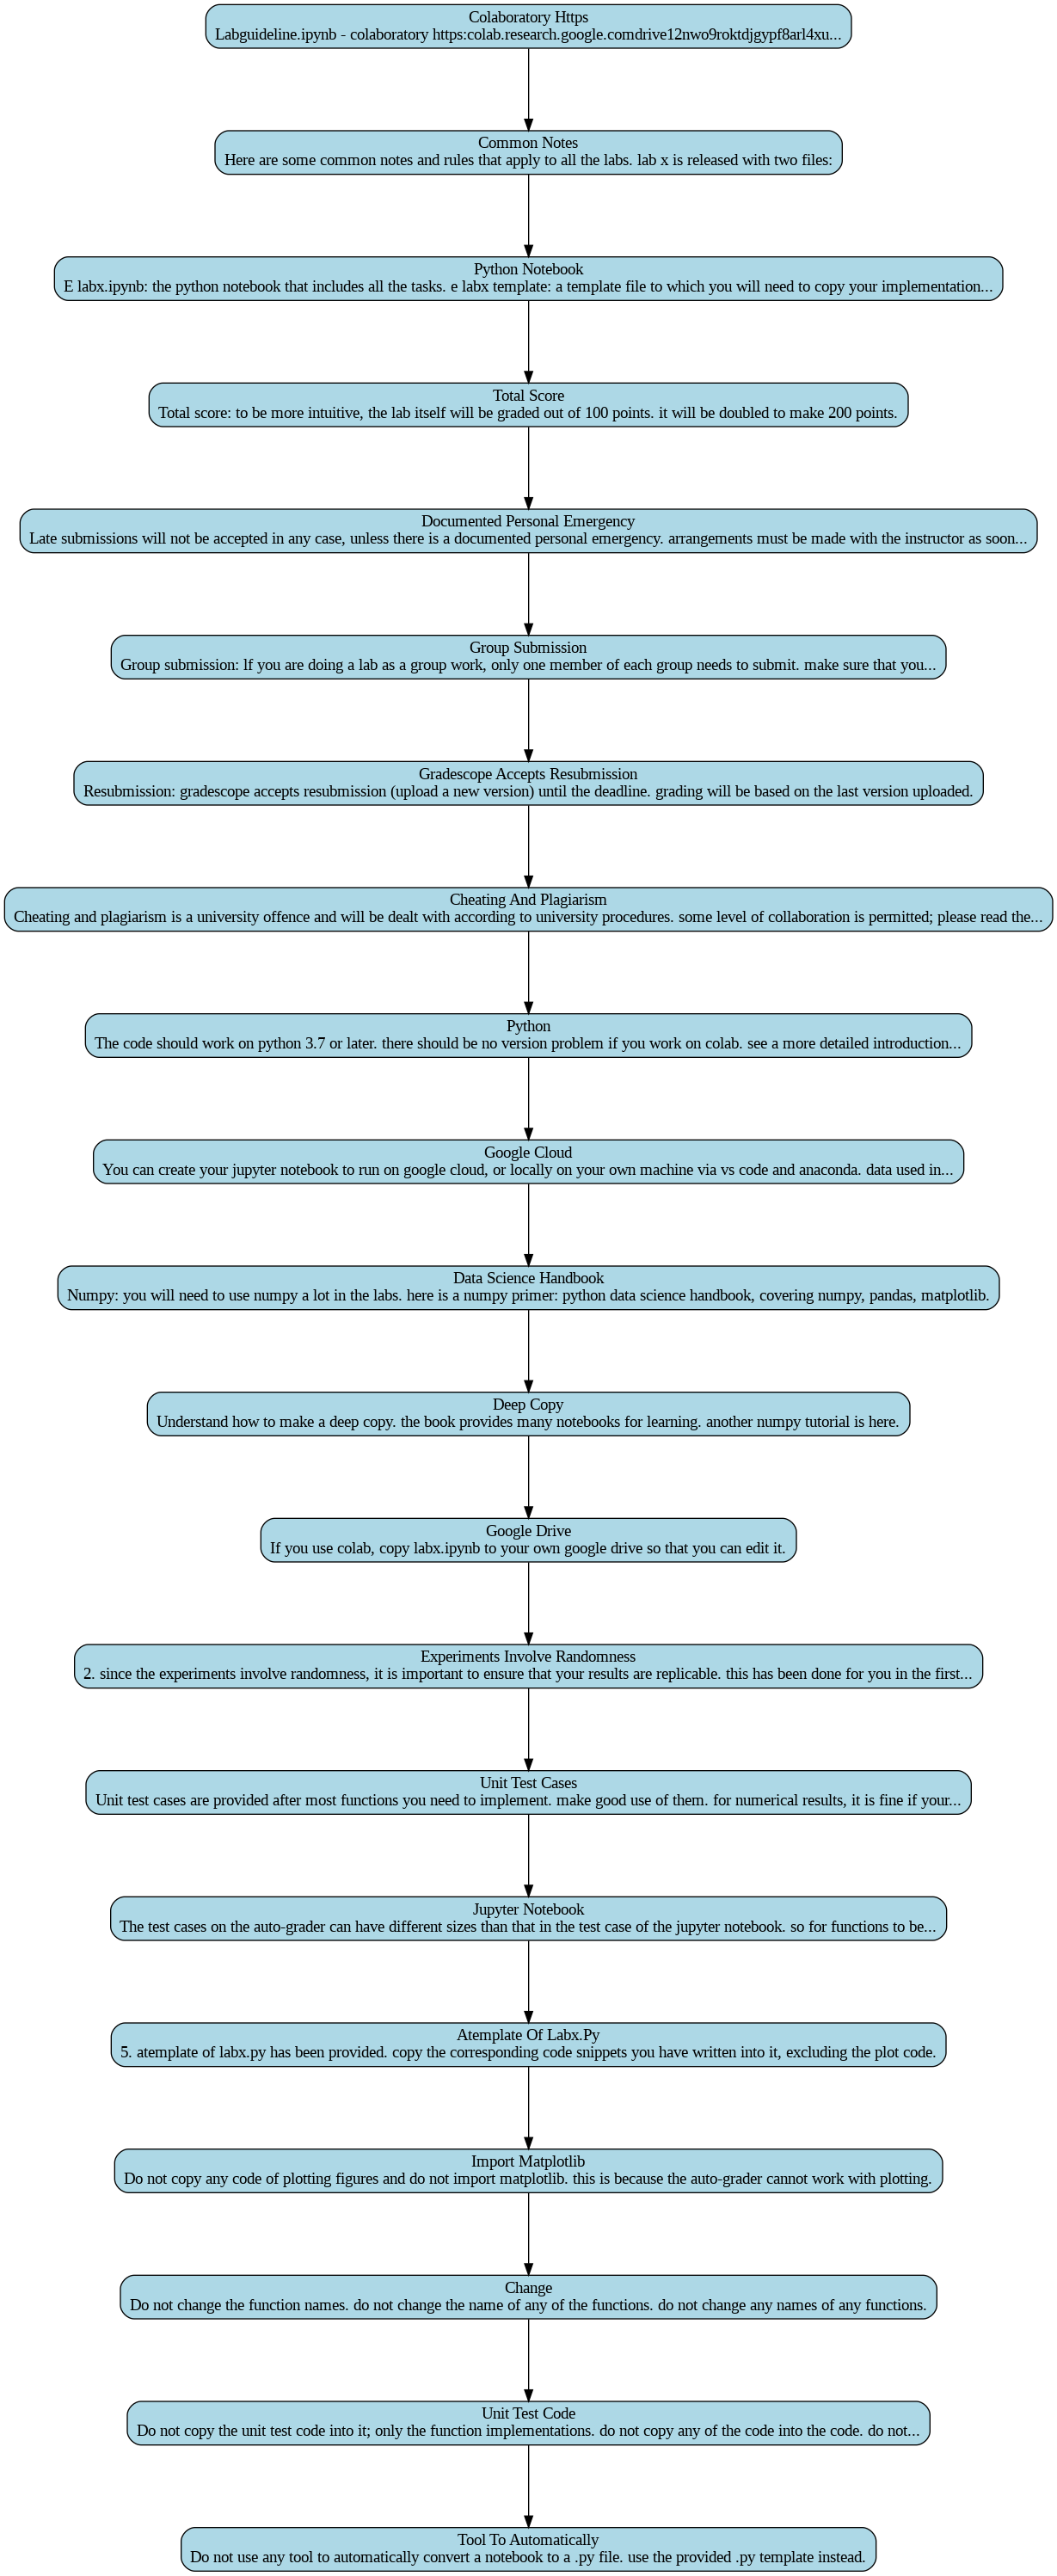

In [ ]:
import yake
from graphviz import Digraph
from IPython.display import Image

kw_extractor = yake.KeywordExtractor(lan="en", n=3, top=1)

def get_title_from_para(text):
    """Extracts a meaningful title or fallback to first few words."""
    try:
        keywords = kw_extractor.extract_keywords(text)
        if keywords:
            return keywords[0][0].title()
        else:
            return " ".join(text.split()[:4]).title()
    except:
        return "Untitled"

titles = list(map(get_title_from_para, final_summaries))

def format_summary(text, max_words=25):
    """Ensure clean, readable one-liners."""
    words = text.split()
    formatted = " ".join(words[:max_words])
    if len(words) > max_words:
        formatted += "..."
    return formatted.strip().capitalize()

node_labels = list(map(lambda ts: f"{ts[0]}\n{format_summary(ts[1])}", zip(titles, final_summaries)))

dot = Digraph(comment="Student Revision Flowchart", format="png")
dot.attr(rankdir="TB", nodesep="0.5", ranksep="1", fontsize="12")

list(map(lambda i_ts: dot.node(f"Step{i_ts[0]+1}", i_ts[1], shape="box", style="rounded,filled", fillcolor="lightblue", color="black"), enumerate(node_labels)))

list(map(lambda i: dot.edge(f"Step{i+1}", f"Step{i+2}"), range(len(node_labels)-1)))

dot.render("student_revision_flowchart", format="png", cleanup=True)
Image("student_revision_flowchart.png")


In [ ]:
#from transformers import pipeline
#from graphviz import Digraph
#from IPython.display import Image

#title_gen = pipeline("text2text-generation", model="facebook/bart-large-cnn")
#titles = list(map(lambda s: title_gen("Generate a short title: " + s, max_length=10, do_sample=False)[0]['generated_text'], final_summaries))

#dot = Digraph(comment="Student Revision Flowchart", format="png")
#list(map(lambda i_ts: dot.node(f"Step{i_ts[0]+1}", i_ts[1]), enumerate(titles)))
#list(map(lambda i: dot.edge(f"Step{i+1}", f"Step{i+2}"), range(len(titles)-1)))

#dot.render("student_revision_flowchart_titles_only", format="png", cleanup=True)
#Image("student_revision_flowchart_titles_only.png")
